 # 回帰2:住宅の平均価格の予測

In [23]:
import unittest
import doctest
import os

from domain import SQLRepository, convert_categoricals, CategoricalData, DataVisualization

path = os.path.dirname(os.path.abspath(__file__))
repo = SQLRepository(table='Boston')
#repo = CSVRepository(file=path + '/data/Boston.csv')

 ## データの内容
 | 列名 | 内容 |
 | --- | --- |
 | CRIME | その地域の犯罪発生率(high,low,very_low)|
 | ZN | 25,000平方フィート以上の住居区画の占める割合 |
 | INDUS | 小売業以外の商業が占める面積の割合 |
 | CHAS | チャールズ川の付近かどうかによるダミー変数(1:川の周辺, 0:それ以外) |
 | NOX | 窒素酸化物の濃度 |
 | RM | 住居の平均部屋数 |
 | AGE | 1940年より前に建てられた物件の割合 |
 | DIS | ボストン市内の5つの雇用施設からの距離 |
 | RAD | 環状高速道路へのアクセスしやすさ |
 | TAX | $10,000ドルあたりの不動産税率の総計 |
 | PTRATIO | 町ごとの教員1人当たりの児童生徒数 |
 | B | 町ごとの黒人(Bk)の比率を次の式で表したもの。1000(Bk - 0.63)^2 |
 | LSTAT | 人口における低所得者の割合 |
 | PRICE | 住宅価格の平均価格 |

In [24]:
df = repo.get_data()
df.head(3)

,ID,CRIME,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0,high,0.0,18.10,0,0.718,3.561,87.9,1.6132,24.0,666,20.2,354.70,7.12,27.5
1,1,low,0.0,8.14,0,0.538,5.950,82.0,3.9900,4.0,307,21.0,232.60,27.71,13.2
2,2,very_low,82.5,2.03,0,0.415,6.162,38.4,6.2700,2.0,348,14.7,393.77,7.43,24.1


 ## 問題背景

 ## データ分析の方法検討
 ボストン市内の特定の地域の住宅価格を予測する回帰式を作成し、どのような地域だと価格が高くなりやすいかを考察する。

 分析の実施

 ### データの概要

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ID       100 non-null    int64  
 1   CRIME    100 non-null    object 
 2   ZN       100 non-null    float64
 3   INDUS    100 non-null    float64
 4   CHAS     100 non-null    int64  
 5   NOX      99 non-null     float64
 6   RM       100 non-null    float64
 7   AGE      100 non-null    float64
 8   DIS      100 non-null    float64
 9   RAD      99 non-null     float64
 10  TAX      100 non-null    int64  
 11  PTRATIO  100 non-null    float64
 12  B        100 non-null    float64
 13  LSTAT    100 non-null    float64
 14  PRICE    100 non-null    float64
dtypes: float64(11), int64(3), object(1)
memory usage: 11.8+ KB


 ### データの統計量

In [26]:
df.describe()

,ID,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,100.000000,100.000000,100.00000,100.000000,99.000000,100.000000,100.000000,100.000000,99.000000,100.000000,100.00000,100.000000,100.000000,100.000000
mean,49.500000,9.895000,10.25870,0.050000,0.543354,6.235930,65.579000,3.948910,8.747475,381.120000,18.51700,372.658600,11.826400,23.457000
std,29.011492,21.261039,6.30552,0.219043,0.111871,0.768287,28.014034,2.079704,8.343815,161.140586,1.94251,59.477814,6.830843,9.570211
min,0.000000,0.000000,1.91000,0.000000,0.392000,3.561000,6.000000,1.178100,1.000000,188.000000,13.00000,27.490000,1.920000,5.000000
25%,24.750000,0.000000,5.32000,0.000000,0.451000,5.870500,42.475000,2.363400,4.000000,276.000000,17.60000,376.132500,6.772500,17.800000
50%,49.500000,0.000000,7.38000,0.000000,0.507000,6.135500,68.450000,3.560000,5.000000,307.000000,18.65000,392.580000,10.445000,21.500000
75%,74.250000,3.125000,18.10000,0.000000,0.609500,6.457250,89.025000,5.117025,8.000000,430.500000,20.20000,396.397500,14.482500,24.800000
max,99.000000,95.000000,25.65000,1.000000,0.871000,8.704000,100.000000,10.585700,24.000000,666.000000,22.00000,396.900000,30.590000,50.000000


 ### データの特徴量の相関確認

In [27]:
categorical_cols = ['PRICE']
df_conv = convert_categoricals(df, categorical_cols)
df_conv.corr()

,ID,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
ID,1.000000,-0.055896,0.097731,-0.043712,0.070360,-0.086694,0.062875,-0.059059,0.032424,0.059203,0.002590,0.093768,0.120334,-0.118742
ZN,-0.055896,1.000000,-0.413801,-0.020551,-0.459571,0.172917,-0.484837,0.593037,-0.254731,-0.257640,-0.262523,0.145139,-0.337898,0.245650
INDUS,0.097731,-0.413801,1.000000,0.157138,0.803621,-0.421951,0.620097,-0.676479,0.650430,0.743518,0.282389,-0.324724,0.562670,-0.512754
CHAS,-0.043712,-0.020551,0.157138,1.000000,0.129395,0.072048,0.096141,-0.118997,0.095917,0.103137,-0.030505,0.017520,-0.061717,0.069790
NOX,0.070360,-0.459571,0.803621,0.129395,1.000000,-0.297559,0.698213,-0.757913,0.624347,0.693711,0.099182,-0.371288,0.507267,-0.444202
RM,-0.086694,0.172917,-0.421951,0.072048,-0.297559,1.000000,-0.201136,0.095502,-0.277143,-0.354765,-0.363856,0.099481,-0.560947,0.591992
AGE,0.062875,-0.484837,0.620097,0.096141,0.698213,-0.201136,1.000000,-0.696931,0.402114,0.441867,0.147185,-0.231157,0.471668,-0.482590
DIS,-0.059059,0.593037,-0.676479,-0.118997,-0.757913,0.095502,-0.696931,1.000000,-0.470488,-0.499881,-0.083598,0.237879,-0.380318,0.189752
RAD,0.032424,-0.254731,0.650430,0.095917,0.624347,-0.277143,0.402114,-0.470488,1.000000,0.945465,0.441143,-0.378279,0.317426,-0.311677
TAX,0.059203,-0.257640,0.743518,0.103137,0.693711,-0.354765,0.441867,-0.499881,0.945465,1.000000,0.409159,-0.383749,0.367904,-0.412400


 ### データの数値変数確認

In [28]:
df.select_dtypes(include='number').columns

Index(['ID', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'PRICE'],
      dtype='object')

 ### データのカテゴリ変数確認

In [29]:
df.select_dtypes(include='object').columns

Index(['CRIME'], dtype='object')

 ### CRIMEカテゴリ

In [30]:
crime = CategoricalData(df, 'CRIME')

In [31]:
crime.show()

very_low    50
high        25
low         25
Name: CRIME, dtype: int64

<Axes: >

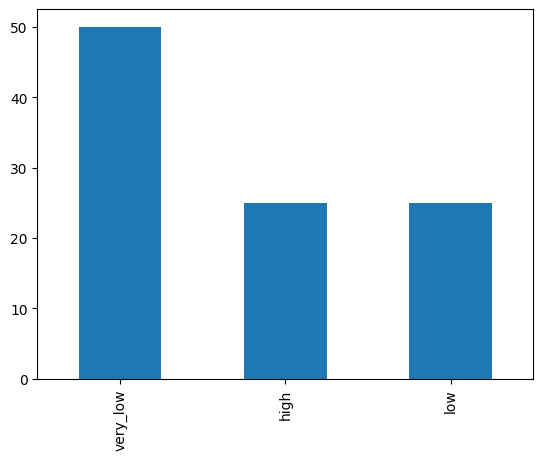

In [32]:
crime.plot()

## %% [markdown]
# ### 種類カテゴリの数値変換

<Axes: >

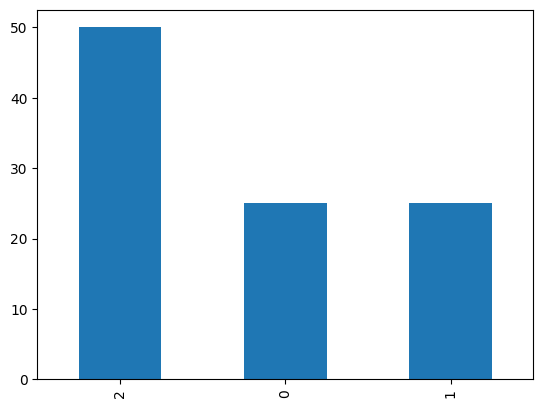

In [33]:
categorical_cols = ['CRIME']
df_conv = convert_categoricals(df, categorical_cols)
conv_species = CategoricalData(df_conv, 'CRIME')
conv_species.plot()

 ### ダミー変数化

In [34]:
df_dummy = crime.dummy()
df_dummy

,ID,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE,CRIME_high,CRIME_low,CRIME_very_low
0,0,0.0,18.10,0,0.718,3.561,87.9,1.6132,24.0,666,20.2,354.70,7.12,27.5,1,0,0
1,1,0.0,8.14,0,0.538,5.950,82.0,3.9900,4.0,307,21.0,232.60,27.71,13.2,0,1,0
2,2,82.5,2.03,0,0.415,6.162,38.4,6.2700,2.0,348,14.7,393.77,7.43,24.1,0,0,1
3,3,0.0,21.89,0,0.624,6.151,97.9,1.6687,4.0,437,21.2,396.90,18.46,17.8,0,1,0
4,4,0.0,18.10,0,0.614,6.980,67.6,2.5329,24.0,666,20.2,374.68,11.66,29.8,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,0.0,18.10,0,0.740,6.219,100.0,2.0048,24.0,666,20.2,395.69,16.59,18.4,1,0,0
96,96,0.0,18.10,0,0.655,5.759,48.2,3.0665,24.0,666,20.2,334.40,14.13,19.9,1,0,0
97,97,0.0,18.10,0,0.671,6.380,96.2,1.3861,24.0,666,20.2,396.90,23.69,13.1,1,0,0
98,98,0.0,9.90,0,0.544,5.914,83.2,3.9986,4.0,304,18.4,390.70,18.33,17.8,0,1,0


 ### データの可視化

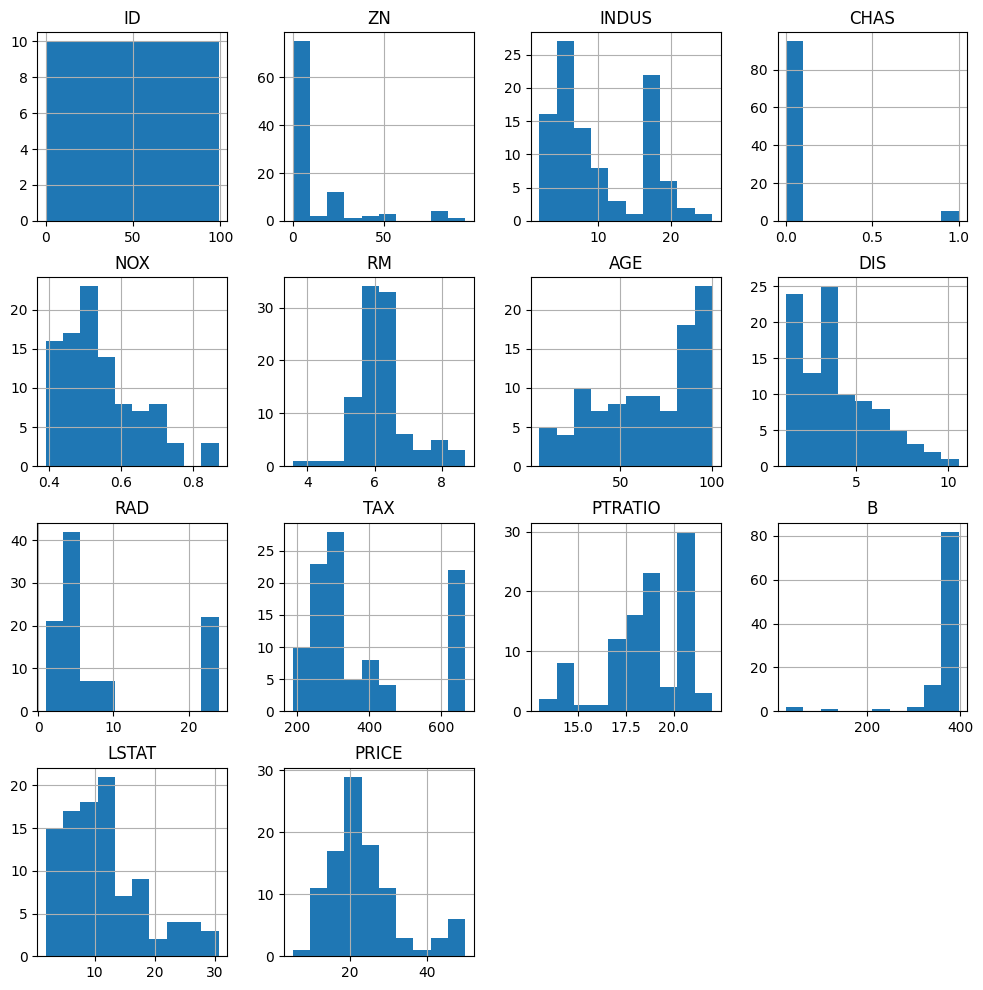

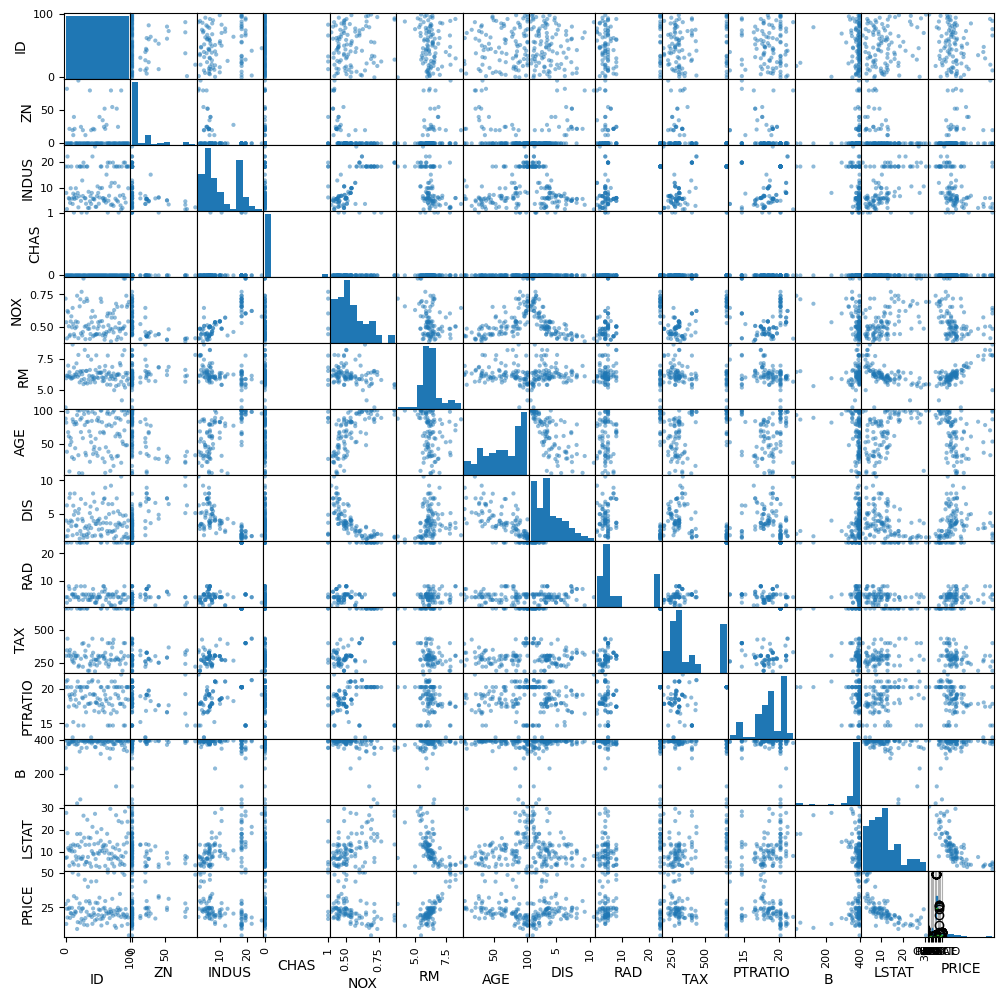

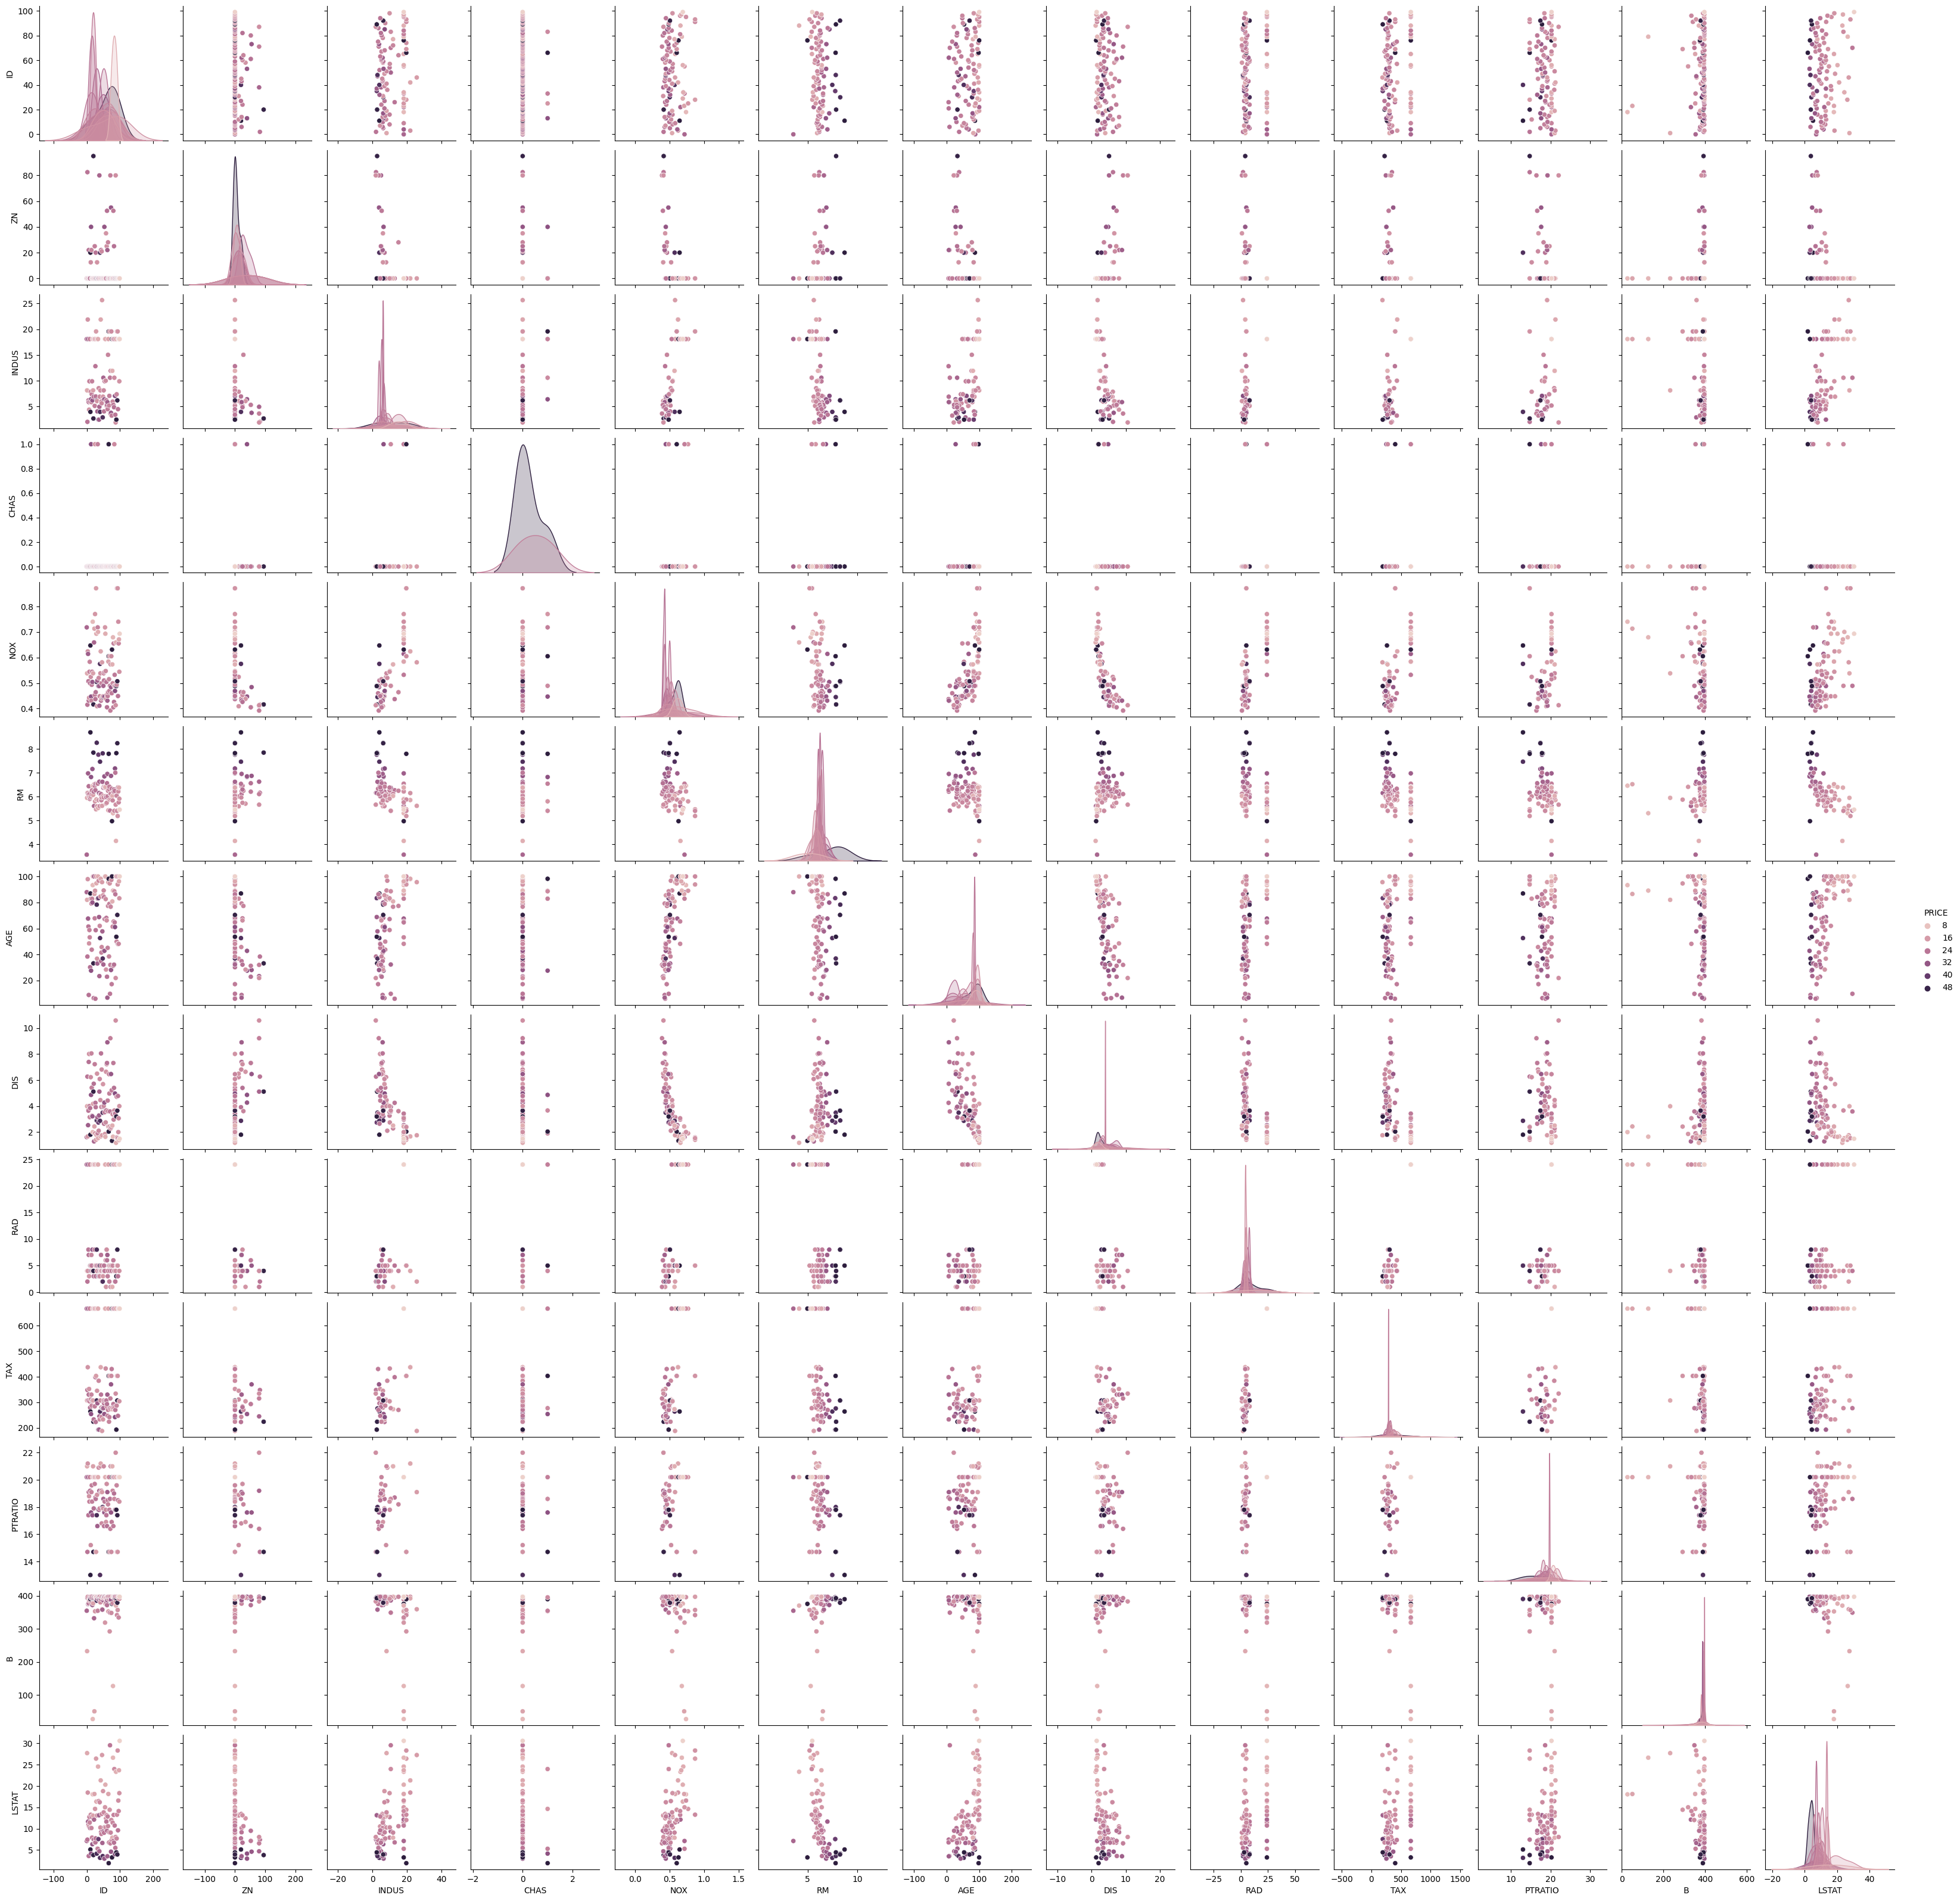

In [35]:
dv = DataVisualization(df)
dv.df_all('PRICE')

 ## データの前処理

 ### 欠損地処理（行削除・全体代表値埋め、グループ代表値埋め）

 ### 各手法を必要に応じて実施

 - 外れ値の除外
 - 多項式特徴量・交互作用特徴量の追加
 - 特徴量の絞り込み
 - 標準化

 ## モデルの作成と学習

 ### 未学習状態モデルの生成（分類なら決定木、回帰なら線形回帰）

 ### 訓練データで学習（必要に応じて不均衡データ補正）

 ## モデルの評価

 ### 検証データで評価し指標確認（分類なら正解率、回帰なら決定係数）

 ### NG:改善案検討前処理に戻る
 ### OK:最終性能評価（テストデータで評価）

In [36]:
doctest.testmod(verbose=True)
unittest.main(argv=[''], verbosity=2, exit=False)

3 items had no tests:
    __main__
    __main__.__VSCODE_compute_hash
    __main__.__VSCODE_wrap_run_cell
0 tests in 3 items.
0 passed and 0 failed.
Test passed.



----------------------------------------------------------------------
Ran 0 tests in 0.000s

OK
